## Import Necessary Libraries

In [1]:
import numpy as np
import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import scikitplot
from scikitplot.metrics import plot_confusion_matrix

# Create a Dataframe for reading and analysing the text files easily

In [2]:
df_train = pd.read_csv('../input/emotions-dataset-for-nlp/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../input/emotions-dataset-for-nlp/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('../input/emotions-dataset-for-nlp/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [3]:
df_train.Sentiment.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

## Reading the Train and Validation Data

In [4]:
X=df_train['Input']


In [5]:
lst=[]
for i in X:
  lst.append(len(i))


In [6]:
len1=pd.DataFrame(lst)
len1.describe()

,0
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


In [7]:
cts=[]
for i in range(7,301):
   ct=0
   for k in lst:
     if k==i:
       ct+=1
   cts.append(ct)

# Trying to fix a length for the embedding layers' input

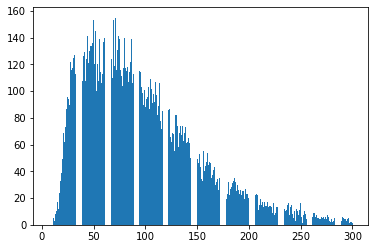

In [8]:
plt.bar(range(7,301),cts)
plt.show()

# Using The tokenizer Class to convert the sentences into word vectors

In [9]:
tokenizer=Tokenizer(15212,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(X)

In [10]:
len(tokenizer.word_index)

15213

In [11]:
X_train=tokenizer.texts_to_sequences(X)
X_train_pad=pad_sequences(X_train,maxlen=80,padding='post')

In [12]:
df_train['Sentiment']=df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [13]:
Y_train=df_train['Sentiment'].values


# One hot Encoding the Emotion Values

In [14]:
Y_train_f=to_categorical(Y_train)

In [15]:
Y_train_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [16]:
X_val=df_val['Input']
Y_val=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [17]:
X_val_f=tokenizer.texts_to_sequences(X_val)
X_val_pad=pad_sequences(X_val_f,maxlen=80,padding='post')

In [18]:
Y_val_f=to_categorical(Y_val)

In [19]:
Y_val_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [20]:
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout


# Creating a Model

In [21]:
model=Sequential()
model.add(Embedding(15212,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 64)            973568    
_________________________________________________________________
dropout (Dropout)            (None, 80, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 160)           92800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 320)               410880    
_________________________________________________________________
dense (Dense)                (None, 6)                 1926      
Total params: 1,479,174
Trainable params: 1,479,174
Non-trainable params: 0
_________________________________________________________________
None


# Compiling and running the model

In [22]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
hist=model.fit(X_train_pad,Y_train_f,epochs=12,validation_data=(X_val_pad,Y_val_f))

Epoch 1/12
500/500 [==============================] - 15s 30ms/step - loss: 1.2041 - accuracy: 0.5340 - val_loss: 0.5528 - val_accuracy: 0.8150
Epoch 2/12
500/500 [==============================] - 15s 30ms/step - loss: 0.4502 - accuracy: 0.8432 - val_loss: 0.2821 - val_accuracy: 0.9010
Epoch 3/12
500/500 [==============================] - 14s 28ms/step - loss: 0.2720 - accuracy: 0.9056 - val_loss: 0.2203 - val_accuracy: 0.9160
Epoch 4/12
500/500 [==============================] - 14s 28ms/step - loss: 0.1961 - accuracy: 0.9308 - val_loss: 0.1998 - val_accuracy: 0.9180
Epoch 5/12
500/500 [==============================] - 14s 27ms/step - loss: 0.1577 - accuracy: 0.9420 - val_loss: 0.2097 - val_accuracy: 0.9205
Epoch 6/12
500/500 [==============================] - 15s 30ms/step - loss: 0.1329 - accuracy: 0.9501 - val_loss: 0.1725 - val_accuracy: 0.9295
Epoch 7/12
500/500 [==============================] - 14s 27ms/step - loss: 0.1137 - accuracy: 0.9550 - val_loss: 0.1782 - val_accuracy:

# Plotting the Loss and Accuracy Curves

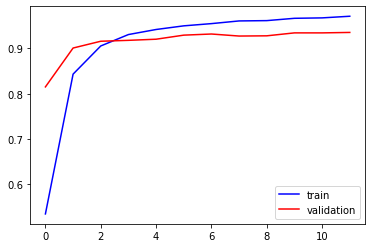

In [24]:
plt.plot(hist.history['accuracy'],c='b',label='train')
plt.plot(hist.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

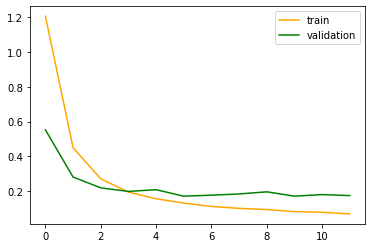

In [25]:
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

# Checking for Test Data

In [26]:
X_test=df_test['Input']
Y_test=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [27]:
X_test_f=tokenizer.texts_to_sequences(X_test)
X_test_pad=pad_sequences(X_test_f,maxlen=80,padding='post')

In [28]:
Y_test_f=to_categorical(Y_test)

In [29]:
X_test_pad.shape

(2000, 80)

In [30]:
Y_test_f[:7]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

#Accuracy for Test Data

In [31]:
model.evaluate(X_test_pad,Y_test_f)

63/63 [==============================] - 1s 8ms/step - loss: 0.1832 - accuracy: 0.9290


[0.18317759037017822, 0.9290000200271606]

# Plotting the Confusion matrix 

In [32]:
Y_pred=model.predict_classes(X_test_pad)

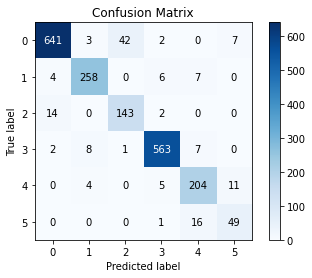

In [33]:
plot_confusion_matrix(Y_test,Y_pred)

In [34]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       695
           1       0.95      0.94      0.94       275
           2       0.77      0.90      0.83       159
           3       0.97      0.97      0.97       581
           4       0.87      0.91      0.89       224
           5       0.73      0.74      0.74        66

    accuracy                           0.93      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



# Creating a Function to check for Your own Sentence

In [35]:
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key



In [36]:
def predict(sentence):
  sentence_lst=[]
  sentence_lst.append(sentence)
  sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
  sentence_padded=pad_sequences(sentence_seq,maxlen=80,padding='post')
  ans=get_key(model.predict_classes(sentence_padded))
  print("The emotion predicted is",ans)

# Check for Your Own Sentence

In [37]:
predict(str(input('Enter a sentence : ')))


Enter a sentence : haha i love it
The emotion predicted is joy


In [38]:
predict(str(input('Enter a sentence : ')))


Enter a sentence : i hate you
The emotion predicted is anger


In [39]:
predict(str(input('Enter a sentence : ')))


Enter a sentence : i am scared of ghosts
The emotion predicted is fear
